In [1]:
%matplotlib inline
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import scipy.io as io
import matplotlib.pylab as plt
from pathlib import Path

8266217.206972408

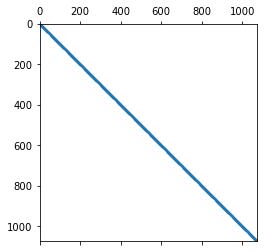

In [2]:
path = "~/Downloads/ch3-3-b2/"
path = "~/Downloads/farm/"
path = "~/Downloads/mesh1em1/"
path = "~/Downloads/pores_1/"
# path = "~/Downloads/bcsstm02/"
path = "~/Downloads/bcsstm08/"
files = list(Path(path).expanduser().glob("*"))

fig, axs = plt.subplots(nrows=1, ncols=len(files))

for i, file in enumerate(files):
    A = io.mmread(file)
    ax = axs[i] if len(files) > 1 else axs
    ax.spy(A, markersize=1)
assert np.all(A.toarray() == A.toarray().T)
np.linalg.cond(A.toarray())

In [3]:
N = A.shape[0]
# b = np.ones((N))
b = np.random.uniform(size=N)
sol = linalg.spsolve(A, b)
np.linalg.norm(A @ sol - b)

/usr/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:168: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


5.925775783607923e-16

In [4]:
def cg(A, b):
    # x = np.random.rand(*b.shape)
    x = np.zeros(b.shape)
    r = b - A @ x
    rr = r.T.dot(r)
    p = r
    for k in range(1000):
        Ap = A @ p # A.dot(p)
        a = rr / p.T.dot(Ap)
        x = x + a * p
        r = r - a * Ap
        rr1 = r.T.dot(r)
        b = rr1 / rr
        rr = rr1
        p = r + b * p
    return x

cg_sol = cg(A, b)

print(A @ cg_sol - b)


[ 1.11022302e-16 -1.38777878e-16  1.11022302e-15 ... -2.22044605e-16
  0.00000000e+00 -8.32667268e-17]


In [5]:
np.linalg.cond(A.toarray())

8266217.206972408

In [6]:
def check(x, b, numtests=5):
    for _ in range(numtests):
        xbad = x + np.random.normal(size=x.shape)
        d = np.linalg.norm(x-b)
        dbad = np.linalg.norm(xbad-b)
        assert dbad > d

def krylov(M, A, r):
    M[0] = r
    for i in range(1, len(M)):
        M[i] = A @ M[i-1]
    return M, M @ r


In [67]:
def cg_algo23(A, b):
    x = np.zeros(*b.shape)
    r = b - A @ x
    p = r
    Ar = A @ r
    rr = r @ r
    rAr = r @ Ar
    a = rr / rAr
    b = 0
    Ap = np.ones(*r.shape)
    for i in range(300):
        p = r + b * p
        Ap = Ar + b * Ap
        x += a * p
        r = r - a * Ap
        Ar = A @ r
        rAr = r @ Ar
        b = r @ r / rr
        rr = r @ r
        a = rr / (rAr - b/a * rr)
    return x

x_sol_23 = cg_algo23(A, b)
r = A @ x_sol_23 - b
print(np.linalg.norm(r))
# assert np.all(np.isclose(r, 0)), "Not a solution."

4.790922148434689e-10


In [41]:

s = 1

x = np.zeros(b.shape)
P = np.zeros([s, len(b)])
Q = np.zeros([s, len(b)])
mu = np.zeros(2*s)
beta = np.zeros([s, s])
c = np.zeros([s, s])

r = b - A @ x
print(np.linalg.norm(r))
residuals = [r]
Q, mu = krylov(Q, A, r)

for i in range(100):
    print(f"{i=}")
    r = Q[0]

    # find beta
    if i > 0:
        Akr = r
        c[0, -1] = - r @ Akr / alpha[-1]
        beta[0] = np.linalg.solve(W, -c[0])
        for k in range(1, s):
            Akr = A @ Akr
            c[k, :-1] = c[k, 1:]
            rest = sum([alpha[-2-t] * c[k, -2-t] for t in range(k)])
            # assert np.isclose(r @ Akr, mu[k])
            c[k, -1] = -1 / alpha[-1] * ((r @ Akr) + rest)
            beta[k] = np.linalg.solve(W, -c[k])

    # find W
    W = np.array([[pj @ A @ pi for pi in Q] for pj in Q])
    # sym = np.isclose(W, W.T); plt.imshow(sym); plt.show(); print(sym)
    
    # find alpha
    m = Q @ r
    alpha = np.linalg.solve(W, m)

    Q += beta @ P
    x += alpha @ Q
    check(x, b)
    
    r = b - A @ x
    print(f"{np.linalg.norm(r)=}")
    residuals.append(r)
    P, mu = krylov(P, A, r)
    P, Q = Q, P



#s_cg_sol = s_cg(A, b)
s_cg_sol = x
print(np.linalg.norm(s_cg_sol @ A - b))

18.72282005528316
i=0
np.linalg.norm(r)=316.7886576050541
i=1
np.linalg.norm(r)=245.4744803737245
i=2
np.linalg.norm(r)=68.46695640379579
i=3
np.linalg.norm(r)=33.1825268513173
i=4
np.linalg.norm(r)=57.205500488235366
i=5
np.linalg.norm(r)=69.3025632200709
i=6
np.linalg.norm(r)=30.069147799831708
i=7
np.linalg.norm(r)=21.834984079212326
i=8
np.linalg.norm(r)=24.554865651644622
i=9
np.linalg.norm(r)=18.618606488913755
i=10
np.linalg.norm(r)=20.441158976453263
i=11
np.linalg.norm(r)=17.205217247852755
i=12
np.linalg.norm(r)=19.138561197256006
i=13
np.linalg.norm(r)=18.26377924593772
i=14
np.linalg.norm(r)=20.29711190184203
i=15
np.linalg.norm(r)=19.312264352719602
i=16
np.linalg.norm(r)=25.56143515330417
i=17
np.linalg.norm(r)=24.299363709070175
i=18
np.linalg.norm(r)=26.35811383057035
i=19
np.linalg.norm(r)=28.91793412180584
i=20
np.linalg.norm(r)=20.344834801723167
i=21
np.linalg.norm(r)=23.435490084234022
i=22
np.linalg.norm(r)=18.667380001550878
i=23
np.linalg.norm(r)=20.978583566106